# TF related analysis

In [1]:
library(Signac)
library(Seurat)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
library(cowplot)
library(viridis)
library(scCustomize)
set.seed(1234)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package

In [2]:
seu <- readRDS('./03_Skin/Mskin_atac_rna_processed.rds')
#####
DefaultAssay(seu) <- "ATAC"
# Get a list of motif position frequency matrices from the JASPAR database
pfm <- getMatrixSet(x = JASPAR2020,opts = list(species = 9606, all_versions = FALSE))
# add motif information
seu_atac <- AddMotifs(object = seu,genome = BSgenome.Mmusculus.UCSC.mm10,pfm = pfm)
seu_atac <- RunChromVAR(object = seu, genome = BSgenome.Mmusculus.UCSC.mm10)

In [3]:
seu@assays

$RNA
Assay data with 28250 features for 64408 cells
Top 10 variable features:
 Ttn, Col2a1, Flg, Hdc, Nrxn3, Nrg3, Dcc, Col11a1, Rbfox1, Grik2 

$ATAC
ChromatinAssay data with 175103 features for 64408 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: TRUE 
Fragment files: 484 

$aRNA
Assay data with 21808 features for 64408 cells
First 10 features:
 Hnf4g, Zfhx4, Pex2, UBC, 1700008P02Rik, Pkia, Zc2hc1a, Il7,
1700010I02Rik, Stmn2 

$SCT
SCTAssay data with 28249 features for 64408 cells, and 1 SCTModel(s) 
Top 10 variable features:
 Krt1, Col1a1, Cmss1, Krt10, Col1a2, Ttn, Col11a1, Hdc, Meg3, Col3a1 

$chromvar
Assay data with 746 features for 64408 cells
First 10 features:
 MA0004.1, MA0006.1, MA0019.1, MA0029.1, MA0030.1, MA0031.1, MA0040.1,
MA0041.1, MA0051.1, MA0057.1 


In [4]:
# de_motif
DefaultAssay(seu_atac) <- "ATAC"
Idents(seu_atac) <- "predicted.id"
da_peaks <- FindAllMarkers(object = seu_atac, only.pos = TRUE, test.use = 'LR',min.pct=0.05,latent.vars='nCount_ATAC') 
# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005, ])
enriched.motifs <- FindMotifs(object = seu_atac, features = top.da.peak)

In [5]:
Idents(seu) <- 'rna_celltype'

In [6]:
DefaultAssay(seu) <- 'chromvar'

In [7]:
seu

An object of class Seurat 
254156 features across 64408 samples within 5 assays 
Active assay: chromvar (746 features, 0 variable features)
 1 layer present: data
 4 other assays present: RNA, ATAC, aRNA, SCT
 6 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap


NOTE: FeaturePlot_scCustom uses a specified `na_cutoff` when plotting to
color cells with no expression as background color separate from color scale.
Please ensure `na_cutoff` value is appropriate for feature being plotted.
Default setting is appropriate for use when plotting from 'RNA' assay.
When `na_cutoff` not appropriate (e.g., module scores) set to NULL to
plot all cells in gradient color palette.

-----This message will be shown once per session.-----
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the ggseqlogo package.
  Please report the issue at <https://github.com/omarwagih/ggseqlogo/issues>.”


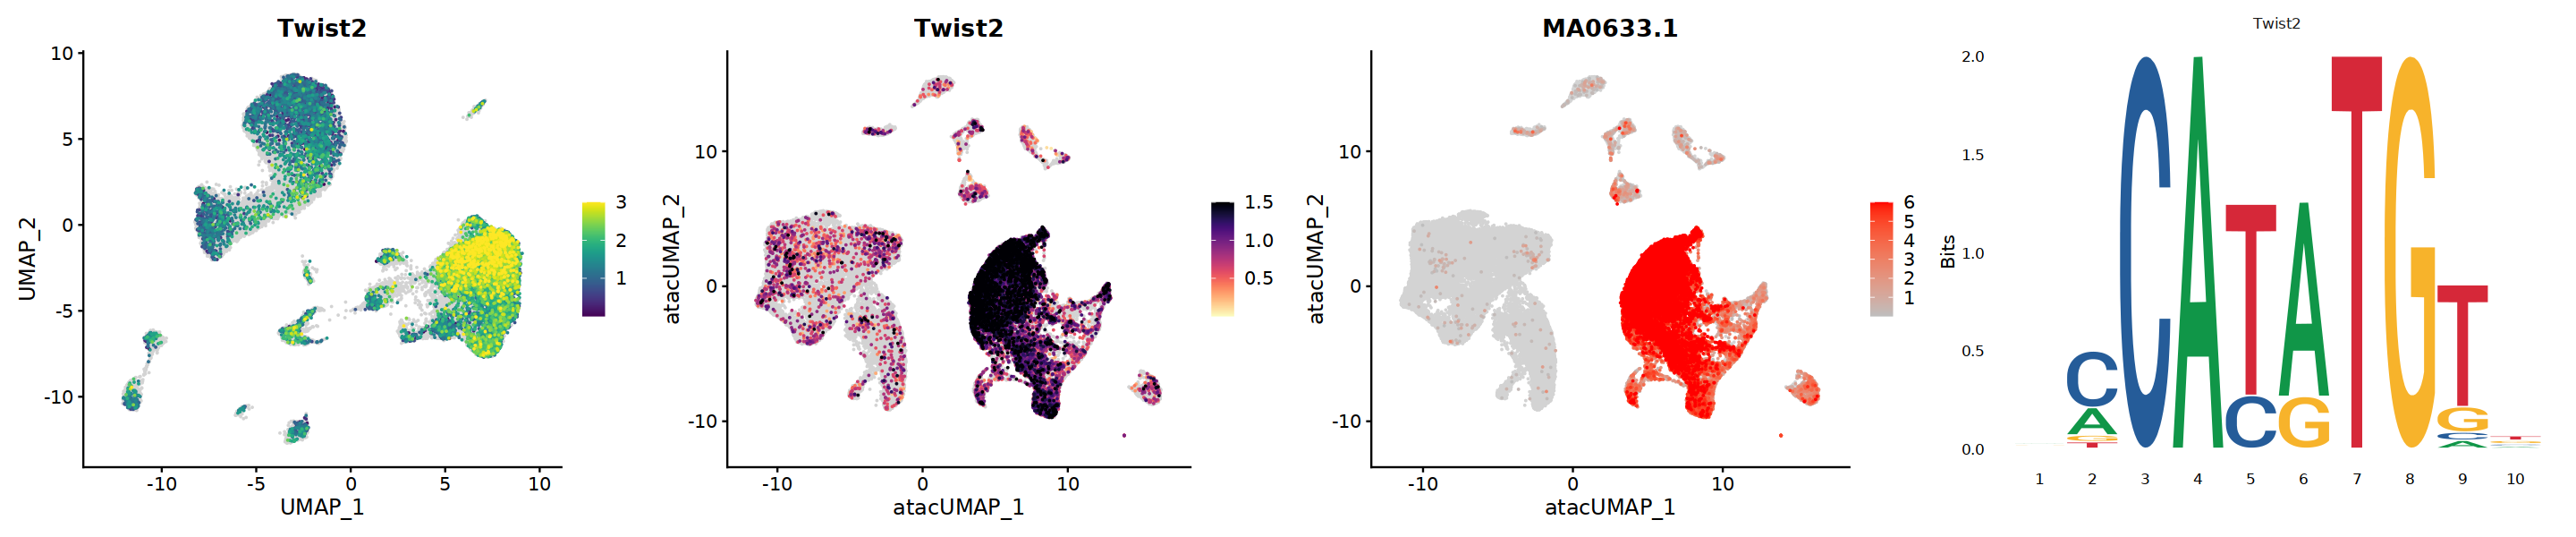

In [8]:
options(repr.plot.width=24, repr.plot.height=5)
DefaultAssay(seu) <- 'RNA'
p1 <- FeaturePlot_scCustom(seurat_object = seu, colors_use = viridis_light_high, features = "Twist2", min.cutoff=0, max.cutoff=3)
DefaultAssay(seu) <- 'aRNA'
p2 <- FeaturePlot_scCustom(seurat_object = seu, colors_use = viridis_magma_dark_high, reduction='umap.atac', features = "Twist2", min.cutoff=0, max.cutoff=1.5)
DefaultAssay(seu) <- 'chromvar'
p3 <- FeaturePlot_scCustom(seurat_object = seu, colors_use = c("grey","red"), reduction='umap.atac', features = "MA0633.1", min.cutoff=0, max.cutoff=6)
DefaultAssay(seu) <- 'ATAC'
p4 <- MotifPlot(object = seu, motifs = "MA0633.1") 
plot_grid(p1, p2, p3, p4, axis = "b", align = "h",ncol = 4)
# ggsave('./03_Skin/Mskin_Twist2_plot.pdf',p1|p2|p3|p4,width=24,height=5)